# Evaluate and fit a ML model on the EC flux tower data 


## Load modules

In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import seaborn as sb
from joblib import dump
import multiprocessing
from pprint import pprint
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
import lightgbm as lgbm
import shap
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import sys
sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools')
from dea_tools.classification import spatial_clusters

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [2]:
model_name = 'AUS'
model_var = 'NEE'

In [3]:
ncpus=multiprocessing.cpu_count()
print('ncpus = '+str(ncpus))

ncpus = 16


## Prepare Data

In [4]:
base = '/g/data/os22/chad_tmp/NEE_modelling/results/training_data/'
sites = os.listdir('/g/data/os22/chad_tmp/NEE_modelling/results/training_data/')

td = []
for site in sites:
    if '.csv' in site:
        xx = pd.read_csv(base+site, index_col='time', parse_dates=True)
        xx['site'] = site[0:5]
        td.append(xx)

ts = pd.concat(td).dropna() #we'll use this later

In [5]:
variables = [
            #'LAI_anom_RS',
             'kNDVI_anom_RS',
             'FPAR_RS',
             'LST_RS',
             'tree_cover_RS',
             'nontree_cover_RS',
             'nonveg_cover_RS',
             'LST-Tair_RS',
             'TWI_RS',
             'NDWI_RS',
             'rain_anom_RS',
             'rain_cml3_anom_RS',
             'rain_cml6_anom_RS',
             'rain_cml12_anom_RS',
             'srad_anom_RS',
             'vpd_RS',
             'tavg_anom_RS',
             'SOC_RS',
             #'CO2_RS',
             'site'
            ]

## Modelling

In [6]:
xx = []
yy = []

for t in td:
    #t = t.drop('PFT_RS', axis=1)  
    t = t.dropna()  # remove NaNS
    df = t.drop(['NEE_SOLO_EC','GPP_SOLO_EC','ER_SOLO_EC'], axis=1) # seperate carbon fluxes
    
    #df = df.filter(regex='RS') # only use remote sensing variables   
    df = df[variables]
    
    if model_var == 'ET':
        df_var=t[model_var+'_EC']
    else:
        df_var=t[model_var+'_SOLO_EC'] # seperate out the variable we're modelling
    
    x = df.reset_index(drop=True)#.to_numpy()
    y = df_var.reset_index(drop=True)#.to_numpy()
    xx.append(x)
    yy.append(y)

x = pd.concat(xx)
y = pd.concat(yy)

print(x.shape)

(2744, 18)


### Specify monotonic constraints for CO2

In [7]:
# m_con= ['1' if col == 'CO2_RS' else '0' for col in x.columns]

## Feature Selection

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#sequentialfeatureselector-the-popular-forward-and-backward-feature-selection-approaches-including-floating-variants

## Test model robustness with time-series K-fold cross validation

* If you set boosting as RF then the lightgbm algorithm behaves as random forest. According to the documentation, to use RF you must use bagging_fraction and feature_fraction smaller than 1


<img src="results/figs/cross_validation.png" width=800>

### Generate five sets of train-test indices

For each site, grab a sequential set of test samples (time-series-split methods), the remaining points (either side of test samples) go into training.  A single K-fold contains test and training samples from every site.

In [15]:
sites = x['site'].unique()
x['original_index'] = [i for i in range(0,len(x))]

train_1=[]
train_2=[]
train_3=[]
train_4=[]
train_5=[]

test_1=[]
test_2=[]
test_3=[]
test_4=[]
test_5=[]

for site in sites:
    df = x.loc[x['site'] == site]
    tscv = TimeSeriesSplit(n_splits=5)
    i=1
    for train, test in tscv.split(df):
        all_indices=np.concatenate([train,test])
        left_over = df.loc[~df.index.isin(all_indices)].index.values
        train = np.concatenate([train, left_over])
        if i==1:
            train_1.append(df.iloc[train]['original_index'].values)
            test_1.append(df.iloc[test]['original_index'].values)
        if i==2:
            train_2.append(df.iloc[train]['original_index'].values)
            test_2.append(df.iloc[test]['original_index'].values)
        if i==3:
            train_3.append(df.iloc[train]['original_index'].values)
            test_3.append(df.iloc[test]['original_index'].values)
        if i==4:
            train_4.append(df.iloc[train]['original_index'].values)
            test_4.append(df.iloc[test]['original_index'].values)
        if i==4:
            train_5.append(df.iloc[train]['original_index'].values)
            test_5.append(df.iloc[test]['original_index'].values)
        i+=1

train_1 = np.concatenate(train_1)
train_2 = np.concatenate(train_2)
train_3 = np.concatenate(train_3)
train_4 = np.concatenate(train_4)
train_5 = np.concatenate(train_5)

test_1 = np.concatenate(test_1)
test_2 = np.concatenate(test_2)
test_3 = np.concatenate(test_3)
test_4 = np.concatenate(test_4)
test_5 = np.concatenate(test_5)

train = [train_1, train_2, train_3, train_4, train_5]
test = [test_1, test_2, test_3, test_4, test_5]

#check there are no train indices in the test indices
for i,j in zip(train, test):
    assert (np.sum(np.isin(i,j)) == 0)

#remove the columns we no longer need
x = x.drop(['site', 'original_index'], axis=1)

### Write out predictor variables to text file

In [9]:
textfile = open("/g/data/os22/chad_tmp/NEE_modelling/results/variables.txt", "w")
for element in x.columns:
    textfile.write(element + ",")
textfile.close()

In [10]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'min_child_samples':[15, 20, 30],
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': [3, 5, 10, 20, 25],
    'n_estimators': [200, 300, 400, 500],
}

In [11]:
# lists to store results of CV testing
acc = []
rmse=[]
r2=[]

i = 1
for train_index, test_index in zip(train, test):
    print(f"Working on {i}/{len(train)} outer cv split", end='\r')
    model = LGBMRegressor(random_state=1,
                          verbose=-1
                          # monotone_constraints=m_con,
                          # monotone_constraints_method='intermediate'
                          )

    # index training, testing
    X_tr, X_tt = x.iloc[train_index, :], x.iloc[test_index, :]
    y_tr, y_tt = y.iloc[train_index], y.iloc[test_index]
    
    #simple random split on inner fold
    inner_cv = KFold(n_splits=5,
                     shuffle=True,
                     random_state=0)
    
    clf = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='r2',
        n_jobs=ncpus,
        refit=True,
        cv=inner_cv.split(X_tr, y_tr),
    )
    #prevents extensive print statements
    clf.fit(X_tr, y_tr, callbacks=None)
    
    # predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # evaluate model w/ multiple metrics
    # r2
    r2_ = r2_score(y_tt, pred)
    r2.append(r2_)
    # MAE
    ac = mean_absolute_error(y_tt, pred)
    acc.append(ac)
    # RMSE
    rmse_ = np.sqrt(mean_squared_error(y_tt, pred))
    rmse.append(rmse_)
    
    #1:1 plots for each fold
    fig,ax = plt.subplots(1,1, figsize=(6,6))
    sb.scatterplot(x=y_tt,y=pred,color="#338844", edgecolor="white", s=50, lw=1, alpha=0.5, ax=ax)
    sb.regplot(x=y_tt, y=pred, scatter=False, color='m', ax=ax)
    sb.regplot(x=y_tt, y=y_tt, color='black', scatter=False, line_kws={'linestyle':'dashed'}, ax=ax);
    
    plt.xlabel('True')
    plt.ylabel('Prediction');
    plt.tight_layout()
    fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/cross_validation/"+str(i)+"_"+model_var+"_lgbm.png")
    plt.close()
    
    i += 1

In [12]:
print("Mean MAE accuracy: "+ str(round(np.mean(acc), 2)))
print("Std dev of MAE accuracy: "+ str(round(np.std(acc), 2)))
print('\n')
print("Mean RMSE: "+ str(round(np.mean(rmse), 2)))
print("Std dev RMSE: "+ str(round(np.std(rmse), 2)))
print('\n')
print("Mean r2: "+ str(round(np.mean(r2), 2)))
print("Std dev r2: "+ str(round(np.std(r2), 2)))

Mean MAE accuracy: 20.29
Std dev of MAE accuracy: 0.91


Mean RMSE: 28.78
Std dev RMSE: 0.91


Mean r2: 0.57
Std dev r2: 0.02


## Optimize model

In [13]:
param_grid = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'min_child_samples':[15, 20, 30],
    'boosting_type': ['gbdt', 'dart'],
    'max_depth': [3, 5, 10, 20, 25],
    'n_estimators': [200, 300, 400, 500],
}

In [ ]:
#generate n_splits of train-test_split
#rs = ShuffleSplit(n_splits=outer_cv_splits, test_size=test_size, random_state=1)

#instatiate a gridsearchCV
clf = GridSearchCV(LGBMRegressor(verbose=-1
                                 # boosting_type='rf',
                                 # bagging_freq=1, 
                                 # bagging_fraction=0.8
                                ),
                   param_grid,
                   scoring='r2',
                   verbose=1,
                   cv=zip(train, test), #using timeseries custom splits here
                  )

clf.fit(x, y, callbacks=None)

In [15]:
print("The most accurate combination of tested parameters is: ")
pprint(clf.best_params_)
print('\n')
print("The MAPE  score using these parameters is: ")
print(round(clf.best_score_, 2))

The most accurate combination of tested parameters is: 
{'boosting': 'dart',
 'max_depth': 5,
 'min_child_samples': 20,
 'n_estimators': 500,
 'num_leaves': 31}


The MAPE  score using these parameters is: 
0.58


## Fit on all data using best params


In [16]:
model = LGBMRegressor(**clf.best_params_)

model.fit(x,y)

LGBMRegressor(boosting='dart', max_depth=5, n_estimators=500)

### Fit upper and lower quantile models

In [17]:
model_lower = LGBMRegressor(objective='quantile', alpha=0.05, **clf.best_params_)
model_lower.fit(x,y)

model_upper = LGBMRegressor(objective='quantile', alpha=0.95, **clf.best_params_)
model_upper.fit(x,y)

LGBMRegressor(alpha=0.95, boosting='dart', max_depth=5, n_estimators=500,
              objective='quantile')

## Save the models

In [19]:
dump(model, '/g/data/os22/chad_tmp/NEE_modelling/results/models/'+model_name+'_'+model_var+'_LGBM_model.joblib')
dump(model_lower, '/g/data/os22/chad_tmp/NEE_modelling/results/models/'+model_name+'_'+model_var+'_LGBM_model_lower.joblib')
dump(model_upper, '/g/data/os22/chad_tmp/NEE_modelling/results/models/'+model_name+'_'+model_var+'_LGBM_model_upper.joblib')

['/g/data/os22/chad_tmp/NEE_modelling/results/models/AUS_NEE_LGBM_model_upper.joblib']

## Predict on all the data

In [18]:
y_pred = model.predict(x)

rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
print("RMSE:", rmse);

RMSE: 13.203


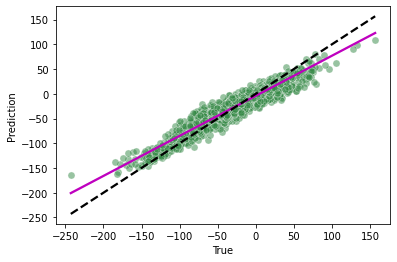

In [19]:
sb.scatterplot(x=y,y=y_pred,color="#338844", edgecolor="white", s=50, lw=1, alpha=0.5)
sb.regplot(x=y, y=y_pred, scatter=False, color='m')
sb.regplot(x=y, y=y, color='black', scatter=False, line_kws={'linestyle':'dashed'});
plt.xlabel('True')
plt.ylabel('Prediction');

## Examine feature importance

SHAP (SHapley Additive exPlanations) is a game theoretic approach to explain the output of any machine learning model

https://github.com/slundberg/shap

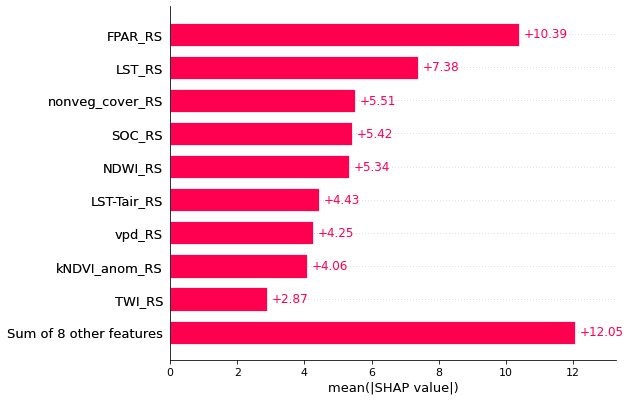

In [20]:
# explain the model's predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(x)

# visualize the first prediction's explanation
# shap.plots.waterfall(shap_values[0])
# shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values)

## Predict the sites time-series to compare

In [21]:
for site in sites:
    print(site)
    df = ts.loc[ts['site'] == site]
    df = df.dropna()
    if model_var == 'ET':
        df_y=df[model_var+'_EC']
    else:
        df_y=df[model_var+'_SOLO_EC'] # seperate out the variable we're modelling
   
    df_x = df[variables]
    df_x = df_x.drop('site', axis=1)
    
    x = df_x.reset_index(drop=True)#.to_numpy()
    y = df_y.reset_index(drop=True)#.to_numpy()

    y_pred = model.predict(x)

    rmse = float(format(np.sqrt(mean_squared_error(y, y_pred)), '.3f'))
    r2_ = r2_score(y, y_pred)
    
    #Compare time-series in a plot
    df_y_true = df[[model_var+'_SOLO_EC']]
    df_y_true['pred_'+model_var] = y_pred 
    
    sb.set_style("darkgrid")
    fig,ax = plt.subplots(1,1, figsize=(12,5))
    sb.lineplot(x='time', y=model_var+'_SOLO_EC', data=df_y_true, color="green", linewidth=1, ax=ax)
    sb.lineplot(x='time', y='pred_'+model_var, data=df_y_true, color="blue", linewidth=1, ax=ax)

    ax.text(.015, .95, 'r = {:.3f}'.format(r2_),
            transform=ax.transAxes)
    ax.text(.015, .9, 'mae = {:.3g}'.format(ac),
            transform=ax.transAxes)

    ax.set_ylabel(model_var)
    ax.set_xlabel(None)
    ax.set_title(site+': '+model_var + ' Cross Validation Results')
    plt.legend(labels=["True","Prediction"], loc='lower left')
    plt.tight_layout()
    fig.savefig("/g/data/os22/chad_tmp/NEE_modelling/results/timeseries_predict/"+site+"_"+model_var+"_LGBM.png")
    plt.close()

Colli
Tumba
CapeT
Boyag
Litch
Silve
Emera
Whroo
Great
Otway
Sturt
FoggD
Gingi
Adela
DalyU
Riggs
Longr
Samfo
Walla
Robso
Warra
Womba
Calpe
Yanco
Alice
Ridge
DryRi
Cumbe
CowBa
